<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/TTYH2_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

## Uncomment these lines if running as a google colab notebook: 
#!pip install numpy==1.15
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks
 

In [3]:
%load_ext autoreload
%autoreload 2  

In [4]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [5]:
#helper utilities for model training and interpretation 
import shap
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

import feature_subsets
import xgboost

/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)



## Neil1 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Degenerate Dataset</a></li>
    <li><a href=#2>Degenerate Dataset: Feature Subsets</a></li>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
    <li><a href=#5>Exclude mut features</a></li>
 </ol>


## NEIL1 Degenerate features<a name='1'>
<a href=#outline>Home</a>

In [4]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/ttyh2_bc_degenerate_computational.features.csv",header=0,sep=',',index_col=0)

In [5]:
data

editing_value  free_energy  sim_nor_score  num_mutations  mut_exist  \
rna_id                                                                        
DG0001         0.8710       -88.46         0.8798              5          1   
DG0001         0.8710       -88.46         0.8798              5          1   
DG0001         0.8710       -88.46         0.8798              5          1   
DG0001         0.8710       -88.46         0.8798              5          1   
DG0001         0.8710       -88.46         0.8798              5          1   
DG0002         0.4685       -87.80         1.0000              1          1   
DG0003         0.4750       -86.09         0.9054              1          1   
DG0004         0.4320       -91.62         0.8571              1          1   
DG0005         0.4280       -87.05         1.0000              0          0   
DG0006         0.4190       -79.98         0.8386              7          1   
DG0006         0.4190       -79.98         0.8386              7          1   
DG0006         0.4190       -79.98         0.8386              7          1   
DG0006         0.4190       -79.98         0.8386              7          1   
DG0006         0.4190       -79.98         0.8386              7          1   
DG0006         0.4190       -79.98         0.8386              7          1   
DG0006         0.4190       -79.98         0.8386              7          1   
DG0007         0.3655       -83.35         0.8843              1          1   
DG0008         0.4125       -83.61         0.8981              5          1   
DG0008         0.4125       -83.61         0.8981              5          1   
DG0008         0.4125       -83.61         0.8981              5          1   
DG0008         0.4125       -83.61         0.8981              5          1   
DG0008         0.4125       -83.61         0.8981              5          1   
DG0009         0.7035       -89.47         0.8872              4          1   
DG0009         0.7035       -89.47         0.8872              4          1   
DG0009         0.7035       -89.47         0.8872              4          1   
DG0009         0.7035       -89.47         0.8872              4          1   
DG0010         0.4075       -75.32         0.8188              9          1   
DG0010         0.4075       -75.32         0.8188              9          1   
DG0010         0.4075       -75.32         0.8188              9          1   
DG0010         0.4075       -75.32         0.8188              9          1   
...               ...          ...            ...            ...        ...   
DG0070         0.0050       -81.87         0.8700              7          1   
DG0070         0.0050       -81.87         0.8700              7          1   
DG0070         0.0050       -81.87         0.8700              7          1   
DG0070         0.0050       -81.87         0.8700              7          1   
DG0071         0.0060       -77.28         0.9699              9          1   
DG0071         0.0060       -77.28         0.9699              9          1   
DG0071         0.0060       -77.28         0.9699              9          1   
DG0071         0.0060       -77.28         0.9699              9          1   
DG0071         0.0060       -77.28         0.9699              9          1   
DG0071         0.0060       -77.28         0.9699              9          1   
DG0071         0.0060       -77.28         0.9699              9          1   
DG0071         0.0060       -77.28         0.9699              9          1   
DG0071         0.0060       -77.28         0.9699              9          1   
DG0072         0.0040       -83.31         0.9635             10          1   
DG0072         0.0040       -83.31         0.9635             10          1   
DG0072         0.0040       -83.31         0.9635             10          1   
DG0072         0.0040       -83.31         0.9635             10          1   
DG0072         0.0040       -83.31         0.9635         

In [6]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [7]:
## prepare data for training with xgboost 
data=format_for_xgboost(data)


(363, 171)


In [8]:
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data[~data['mut_pos'].isna()])
null_mut_pos=data[data['mut_pos'].isna()]
train_split=pd.concat((train_split,null_mut_pos),axis=0)

{24.0: 32, 25.0: 33, 26.0: 41, 27.0: 42, 28.0: 31, 29.0: 23, 30.0: 24, 31.0: 34, 32.0: 25, 33.0: 21, 48.0: 56}


In [9]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [10]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [11]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

d3_length_hairpin
u1_exist
site_3prm_cp_internal:A:U
d3_length_internal_es
d1_5prm_cp_hairpin
d3_5prm_cp_internal
u2_exist
d1_exist
mut_ref_nt:G
u2_3prm_cp_bulge:A:U
u3_5prm_cp_internal
u1_length_internal_es
d3_3prm_cp_internal
d2_length_hairpin
mut_exist
u1_3prm_cp_internal
u3_struct:B
mut_same_as_site
d3_5prm_cp_hairpin
u2_length_internal_ecs
site_5prm_cp_hairpin
u3_length_internal_es
d3_5prm_cp_bulge
u1_5prm_cp_internal
d2_5prm_cp_hairpin
u3_5prm_cp_bulge:G:C
u2_length_internal_es
u3_length_bulge
u3_3prm_cp_internal
mut_prev_struct:H
u3_length_internal_ecs
d3_length_bulge
u1_5prm_cp_hairpin
site_3prm_cp_internal:G:U
d1_length_hairpin
u_hairpin_length
mut_ref_nt:U
u1_length_hairpin
mut_ref_struct:I
mut_ref_struct:S
site_prev_nt:C
site_length_hairpin
d2_5prm_cp_internal:G:C
site_next_nt:G
site_3prm_cp_internal:U:G
d3_length_internal_ecs
u2_length_bulge
mut_type:mismatch
u2_5prm_cp_internal
d3_exist
d3_3prm_cp_bulge
u2_5prm_cp_bulge:U:G
d2_struct:E
d2_5prm_cp_internal:C:G
u3_exist
mut_

In [12]:
#remove teh features that don't change across isoforms , or are null for all isoforms
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [13]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [14]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(224, 106)
(224,)
(53, 106)
(53,)
(67, 106)
(67,)


In [15]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [16]:
## set model training parameters 
from __future__ import unicode_literals
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 

#Note: the last metric in your 'eval_metric' list will get optimized 
param['eval_metric'] = ['aucpr','auc','mae','map','rmse']

In [17]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [18]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[11:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[0]	eval-aucpr:0.563404	eval-auc:0.906765	eval-mae:0.297029	eval-map:1	eval-rmse:0.315982	train-aucpr:0.521818	train-auc:0.879473	train-mae:0.311296	train-map:1	train-rmse:0.322616
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[11:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-aucpr:0.560961	eval-auc:0.906385	eval-mae:0.210959	eval-map:1	eval-rmse:0.224026	train-aucpr:0.528147	train-auc:0.880335	train-mae:0.219446	train-map:1	train-rmse:0.228084
[11:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-aucpr:0.563324	eval-auc:0.90735	eval-mae:0.152419	eval-map:1	eval-rmse:0.160005	train-aucpr:0.545496	train-auc:0.88

[11:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-aucpr:0.567977	eval-auc:0.91676	eval-mae:0.008896	eval-map:1	eval-rmse:0.029683	train-aucpr:0.563889	train-auc:0.916279	train-mae:0.000775	train-map:1	train-rmse:0.001151
[11:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-aucpr:0.568038	eval-auc:0.916846	eval-mae:0.008804	eval-map:1	eval-rmse:0.029657	train-aucpr:0.563917	train-auc:0.916348	train-mae:0.000705	train-map:1	train-rmse:0.001068
[11:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-aucpr:0.568045	eval-auc:0.916876	eval-mae:0.008729	eval-map:1	eval-rmse:0.029598	train-aucpr:0.563926	train-auc:0.916395	train-mae:0.000652	train-map:1	train-rmse:0.000971
[11:53:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extr

In [20]:
# save to binary file for faster loading
bst.save_model('neil1.degenerate.model')
# save model to text file 
bst.dump_model('neil1.degenerate.raw.txt')


In [21]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [22]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred)

Train
	Spearman corr : SpearmanrResult(correlation=0.9933415192808832, pvalue=2.3953072031853932e-210)
	Pearson corr : (0.9999912907667173, 0.0)
	MAE : 0.00044457454887950585
	MAPE : 0.01640215432951738
	RMSE : 0.0006618429637156676
	auPRC : 1.0
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.9378056999669336, pvalue=4.363631266166235e-25)
	Pearson corr : (0.9889842012783044, 5.459593229352884e-44)
	MAE : 0.008517817302905725
	MAPE : 0.09002251864076866
	RMSE : 0.029551535532050213
	auPRC : 1.0
	auROC : 1.0
Test
	Spearman corr : SpearmanrResult(correlation=0.9821998177867822, pvalue=6.272816339253082e-49)
	Pearson corr : (0.9637546459751994, 5.1331897251429066e-39)
	MAE : 0.00794459750403219
	MAPE : 0.04406076156271382
	RMSE : 0.05073455428346116
	auPRC : 0.8333333333333333
	auROC : 0.9923076923076923


In [0]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9962584826459621, pvalue=4.594641797778893e-238)
Eval:SpearmanrResult(correlation=0.9431902690939055, pvalue=4.627391184283365e-26)
Test:SpearmanrResult(correlation=0.9938366081630684, pvalue=8.04398368133661e-64)


Pearson correlation:
Train:(0.9999949276729646, 0.0)
Eval:(0.9878604752824922, 6.413742986246775e-43)
Test:(0.9583237037635896, 4.409288784459115e-37)


In [0]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.00036159653922576115
MAE Eval:0.008684654361761683
MAE Test:0.00836556098710245


In [0]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.3616694520637878%
MAPE Eval:7.6318934054981575%
MAPE Test:3.4550978554397753%


In [0]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0005058915715105989
RMSE Eval:0.031114539660846322
RMSE Test:0.054836940246730616


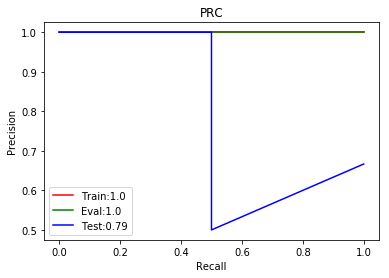

In [0]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

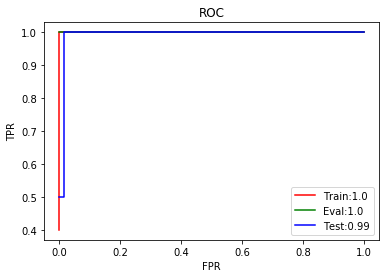

In [0]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

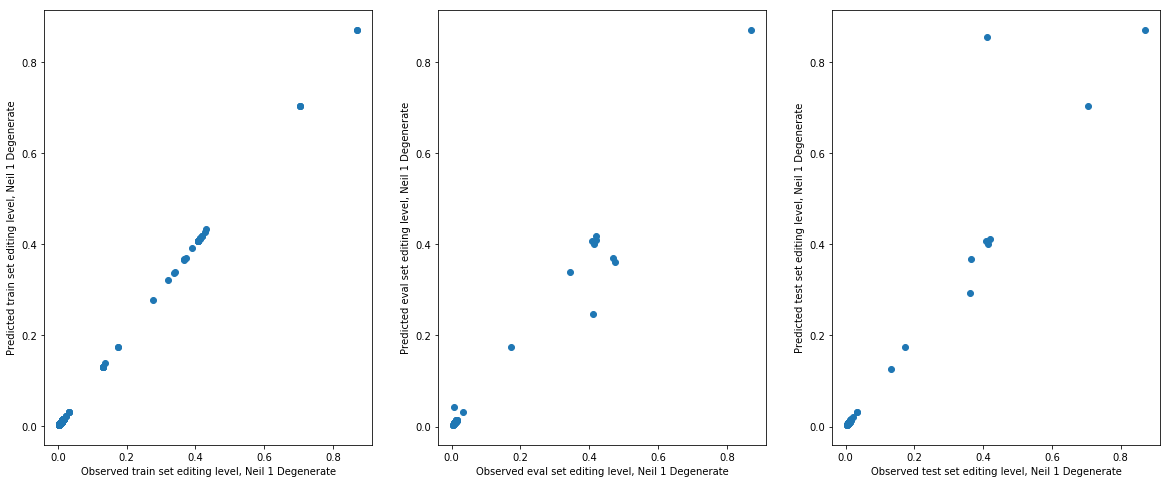

In [0]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

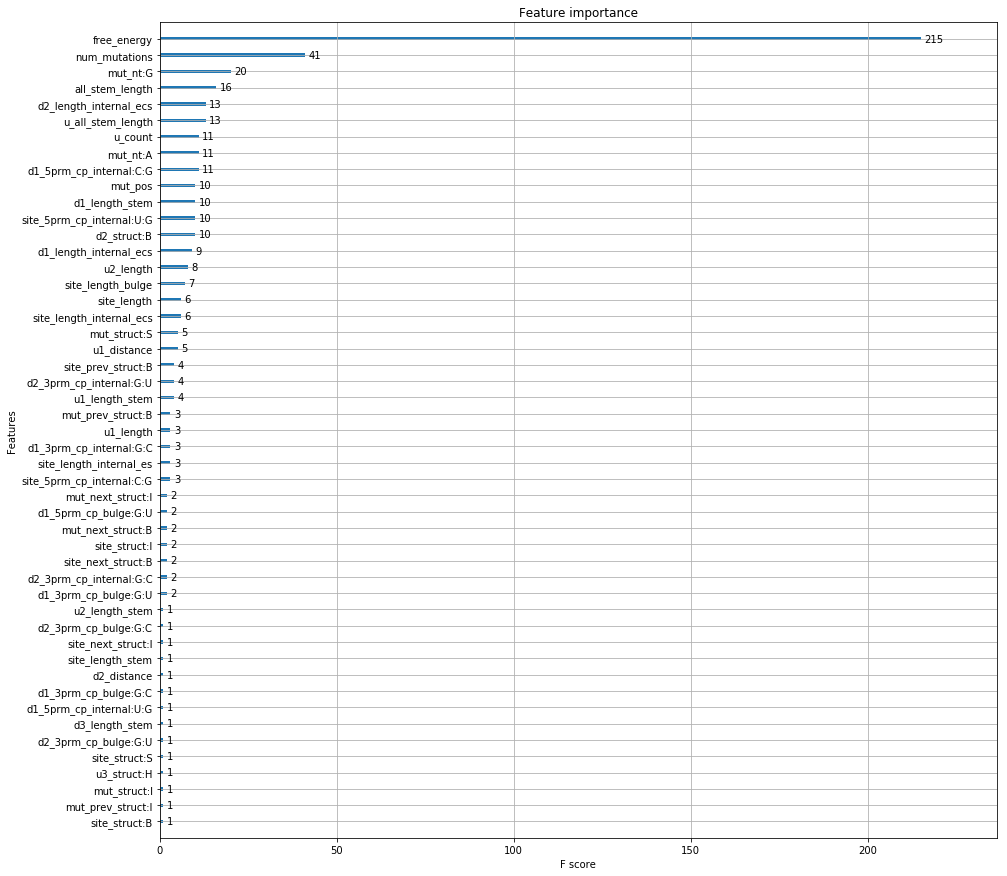

In [0]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

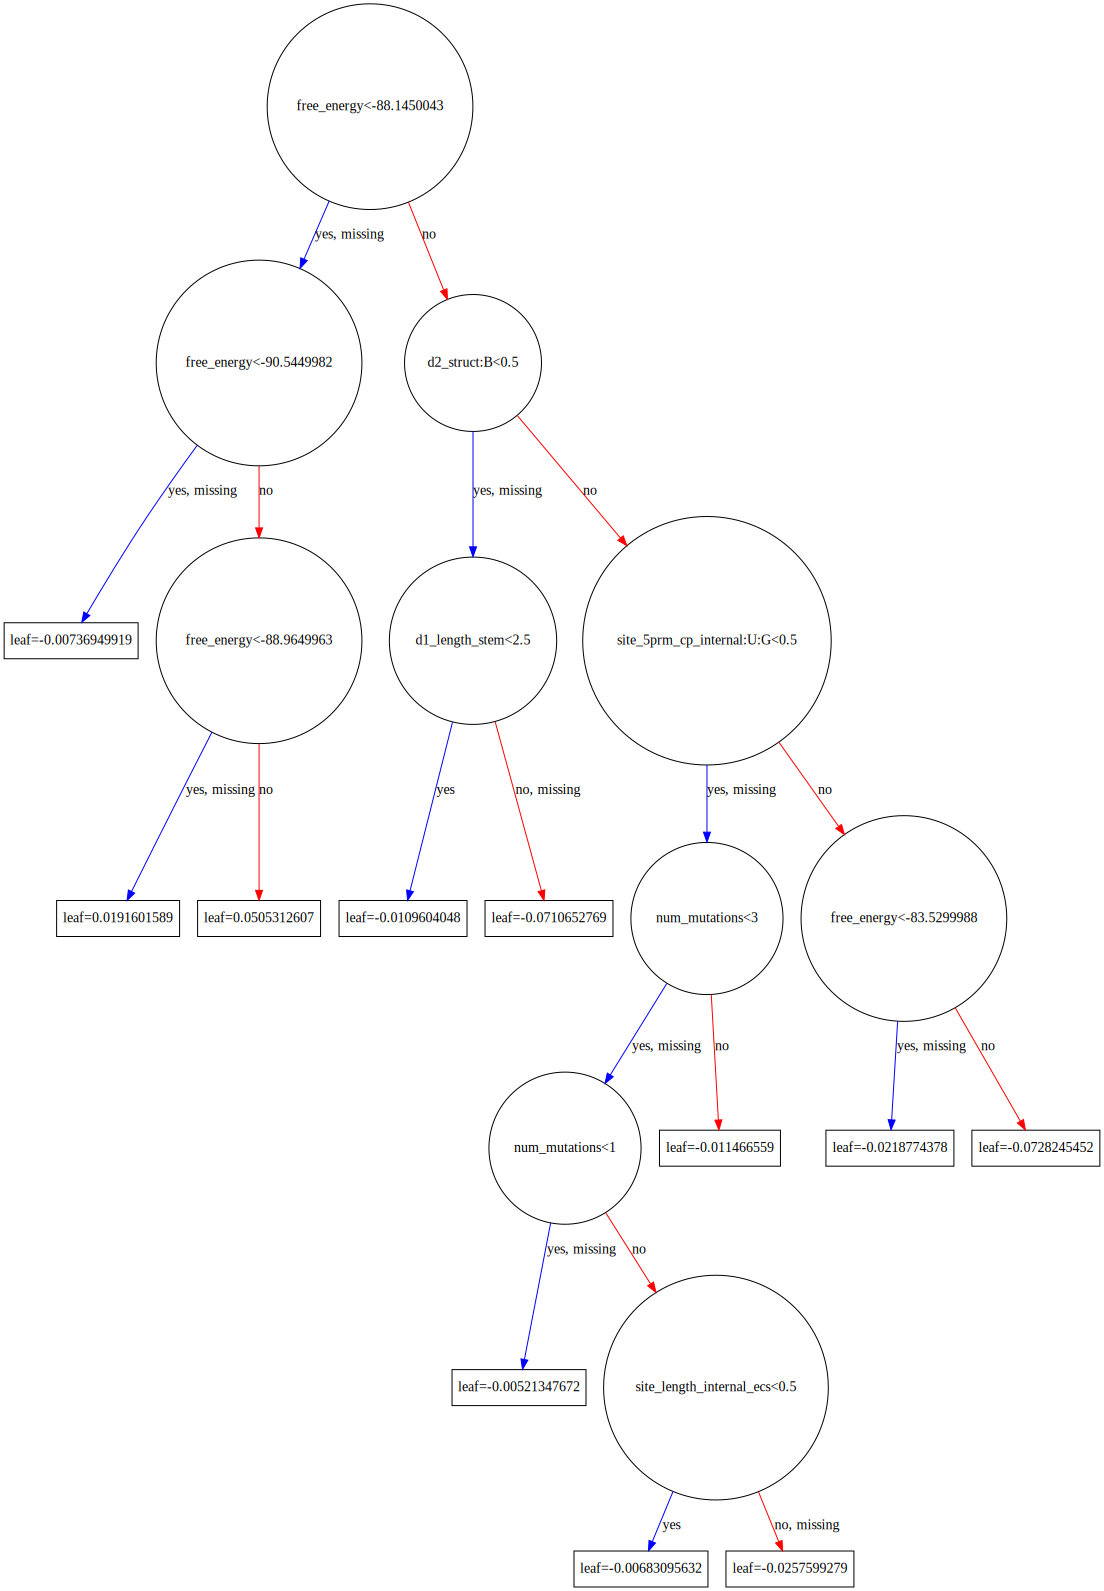

In [0]:
xgboost.to_graphviz(bst, num_trees=2)


In [0]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(67, 104)

In [0]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [0]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [0]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

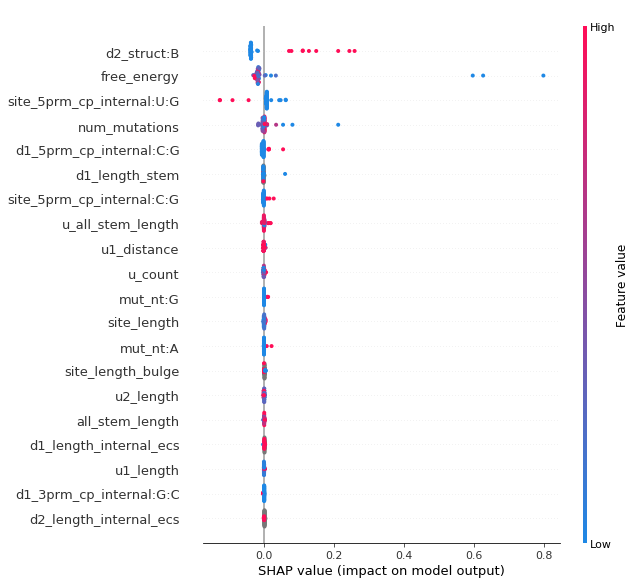

In [0]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


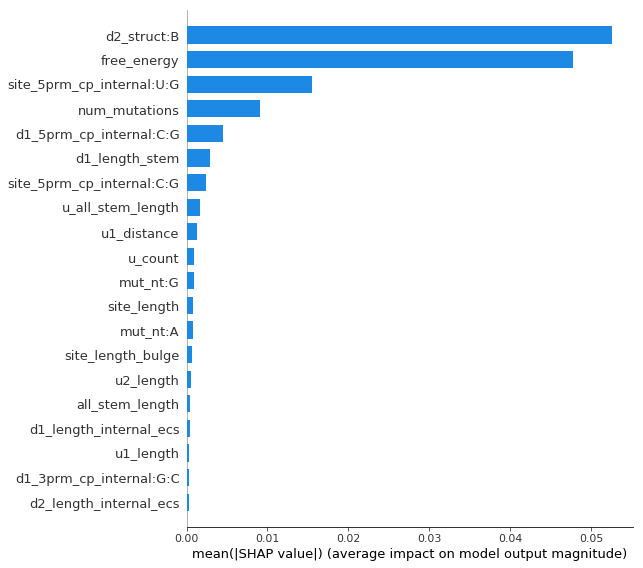

In [0]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [0]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(67, 104, 104)

In [0]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [0]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [0]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Degenerate Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [0]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


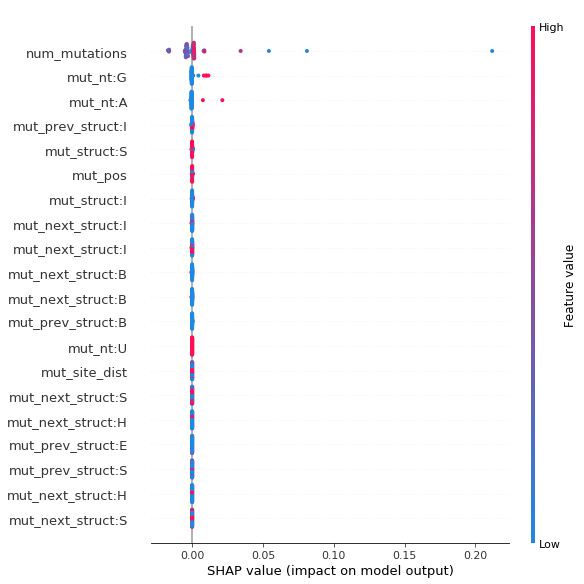

Contribution/Total:0.07585807
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


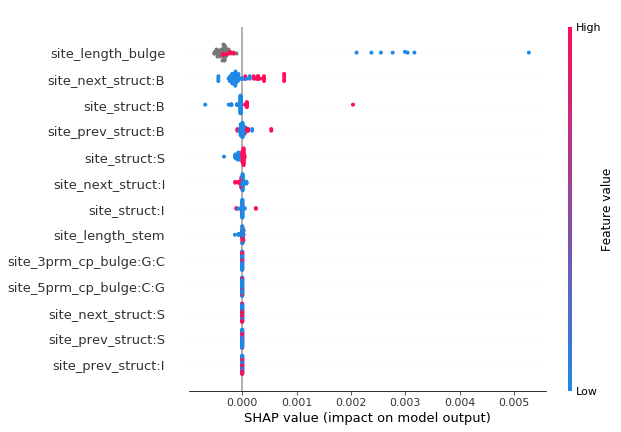

Contribution/Total:0.007791212
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*']


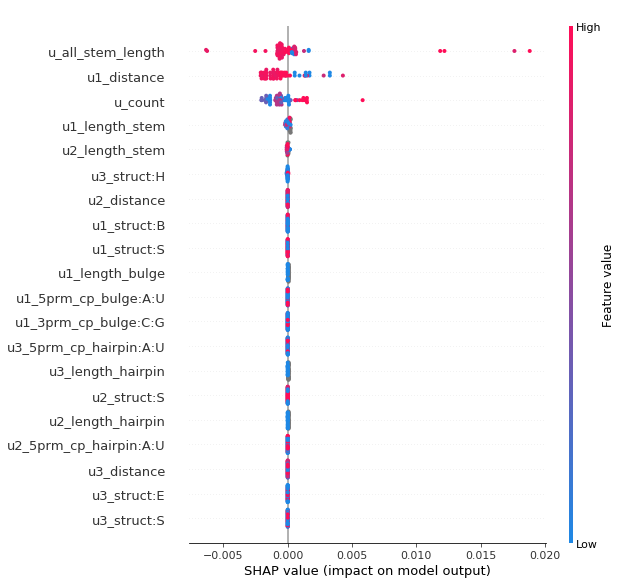

Contribution/Total:0.027749768
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_interior*', 'd2_3prm_cp_interior*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_interior_es*', 'd3_length_interior_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_interior*', 'd3_3prm_cp_interior*']


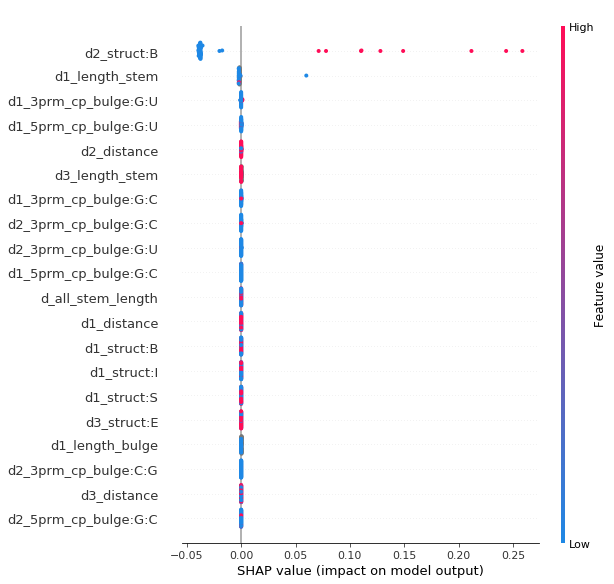

Contribution/Total:0.3825808
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_lengt

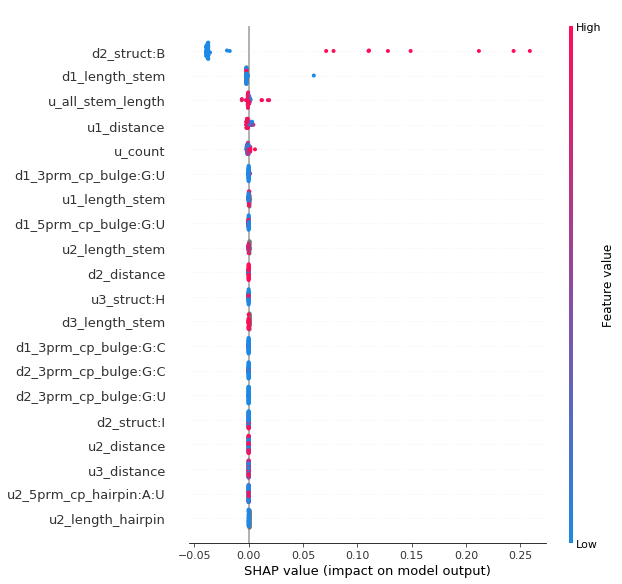

Contribution/Total:0.41033056
['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


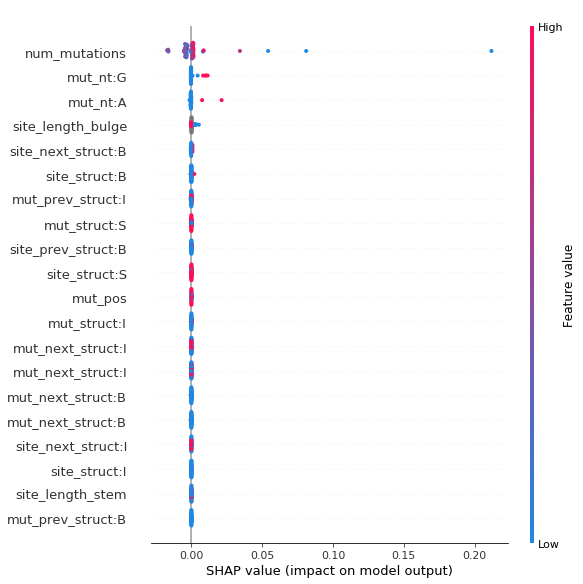

Contribution/Total:0.083649285
['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd

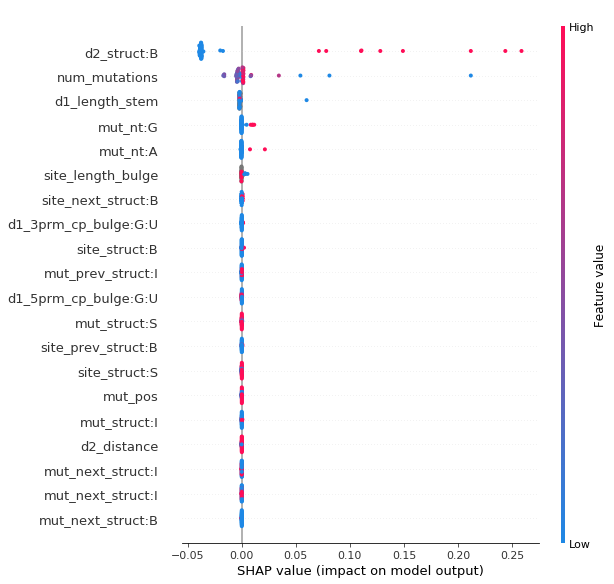

Contribution/Total:0.4662301
['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5p

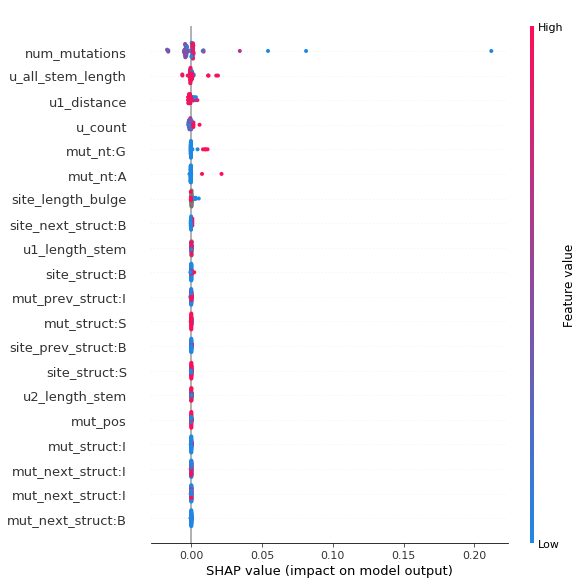

Contribution/Total:0.11139905
['site_struct', 'site_length', 'site_length_interior_es', 'site_length_interior_ecs', 'site_3prm_cp_interior']


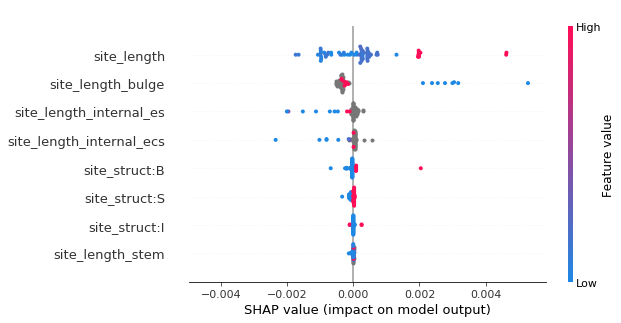

Contribution/Total:0.013444728
['site_prev_nt*', 'site_next_nt*']


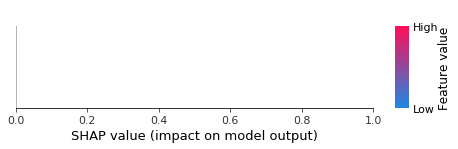

Contribution/Total:0.0
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


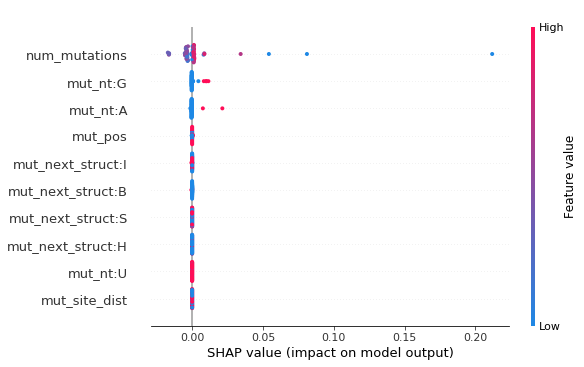

Contribution/Total:0.07422228
['site_prev_nt', 'site_next_nt', 'num_mutations', 'mut_pos', 'mut_site_dist', 'mut_ref_nt, mut_nt']


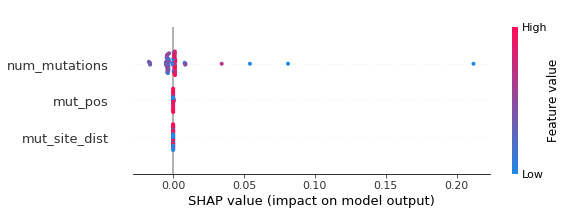

Contribution/Total:0.06256947
['free_energy*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length

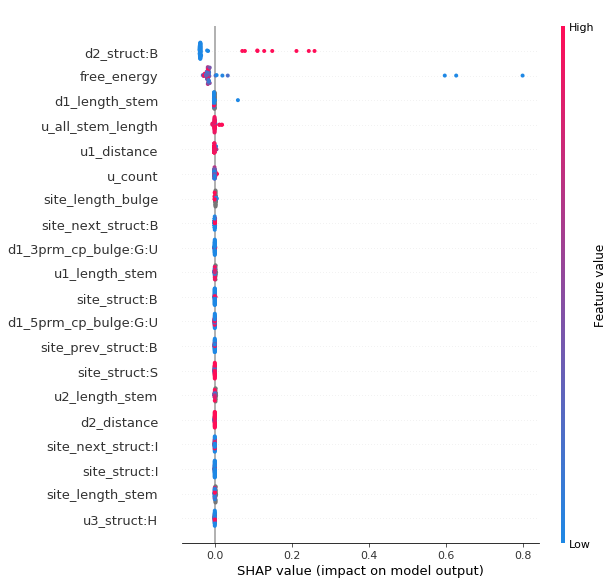

Contribution/Total:0.74570113
['free_energy*', 'all_stem_length*']


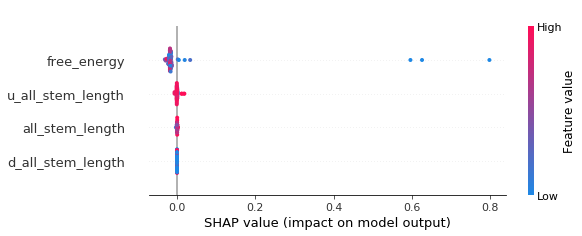

Contribution/Total:0.3417599


In [0]:
from feature_subsets import * 
for subset in [mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_test_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_test_X)#,sort=False,max_display=50)
  print("Contribution/Total:"+str(shap_contribs_subgroup(shap_values,subset)))

## TTYH2 Computational features <a name='3'>
<a href=#outline>Home</a>

In [6]:
import pandas as pd 
import xgboost 

In [7]:
data=pd.read_csv("../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)

In [8]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [9]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(601, 216)
{21.0: 18, 22.0: 18, 23.0: 18, 24.0: 20, 25.0: 17, 26.0: 20, 27.0: 20, 28.0: 20, 29.0: 18, 30.0: 18, 31.0: 17, 32.0: 17, 33.0: 17, 34.0: 18, 35.0: 18, 36.0: 18, 79.0: 17, 80.0: 17, 81.0: 18, 82.0: 18, 83.0: 19, 84.0: 19, 85.0: 20, 86.0: 29, 88.0: 27, 89.0: 18, 90.0: 17, 91.0: 17, 92.0: 17, 93.0: 14, 94.0: 18, 95.0: 18, nan: 0, nan: 0, nan: 0, nan: 0, nan: 6}


In [10]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [11]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [12]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

d3_3prm_cp_bulge:G:C
d1_exist
mut_ref_nt:A
site_3prm_cp_bulge:C:G
u3_3prm_cp_internal
site_next_nt:U
u3_5prm_cp_bulge:C:G
d1_3prm_cp_internal:A:U
d3_3prm_cp_internal:C:G
u2_length_internal_ecs
d2_5prm_cp_internal:U:G
d3_struct:B
d3_5prm_cp_internal:G:C
u1_length_internal_es
d3_5prm_cp_hairpin
d3_5prm_cp_internal:A:U
u2_5prm_cp_internal
d3_5prm_cp_bulge:G:C
u2_exist
u2_5prm_cp_bulge:G:U
mut_exist
u2_5prm_cp_bulge:C:G
d1_5prm_cp_bulge:A:U
mut_type:indel
u2_struct:E
u2_3prm_cp_bulge:G:C
u3_5prm_cp_bulge:G:C
u1_5prm_cp_bulge:U:G
u1_length_internal_ecs
d1_length_hairpin
u3_5prm_cp_internal
mut_ref_nt:U
u3_length_internal_es
mut_ref_struct:I
d3_struct:I
site_length_hairpin
site_5prm_cp_bulge:U:G
d2_length_hairpin
site_5prm_cp_hairpin
u2_length_internal_es
d1_5prm_cp_internal:G:C
d3_length_internal_ecs
u_hairpin_length
u2_3prm_cp_bulge:U:G
mut_type:wt
mut_prev_struct:H
d2_5prm_cp_bulge:G:U
site_prev_nt:A
site_prev_nt:U
u1_3prm_cp_bulge:A:U
site_prev_struct:H
d3_3prm_cp_internal:U:A
d1_5prm_cp

In [13]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [14]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [15]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(409, 133)
(409,)
(105, 133)
(105,)
(93, 133)
(93,)


In [16]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [17]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [18]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [19]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.669929	eval-mae:0.277461	eval-map:1	eval-aucpr:0.19362	eval-rmse:0.29326	train-auc:0.711438	train-mae:0.230588	train-map:1	train-aucpr:0.342422	train-rmse:0.252709
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.720176	eval-mae:0.206191	eval-map:1	eval-aucpr:0.228722	eval-rmse:0.220248	train-auc:0.74098	train-mae:0.164455	train-map:1	train-aucpr:0.358525	train-rmse:0.183177
[2]	eval-auc:0.769343	eval-mae:0.151876	eval-map:1	eval-aucpr:0.247704	eval-rmse:0.163377	train-auc:0.752179	train-mae:0.11857	train-map:1	train-aucpr:0.363026	train-rmse:0.134531
[3]	eval-auc:0.773578	eval-mae:0.115715	eval-map:1	eval-aucpr:0.249425	eval-rmse:0.127523	train-auc:0.753896	train-mae:0.087175	train-map:1	train-aucpr:0.365597	train-rmse:0.100122
[4]	eval-auc:0.778573	eval-mae:0.088408	eval-map:1	eval-aucpr:0.252602	eval-rmse:0.099332	train-auc:0.75703	train-mae:0.06508	train-map

[45]	eval-auc:0.784731	eval-mae:0.030099	eval-map:1	eval-aucpr:0.260528	eval-rmse:0.049368	train-auc:0.76689	train-mae:0.003846	train-map:1	train-aucpr:0.375155	train-rmse:0.005539
[46]	eval-auc:0.784497	eval-mae:0.030111	eval-map:1	eval-aucpr:0.260098	eval-rmse:0.049389	train-auc:0.766905	train-mae:0.003684	train-map:1	train-aucpr:0.375163	train-rmse:0.005369
[47]	eval-auc:0.784263	eval-mae:0.030147	eval-map:1	eval-aucpr:0.259863	eval-rmse:0.049452	train-auc:0.76692	train-mae:0.003553	train-map:1	train-aucpr:0.375176	train-rmse:0.005111
[48]	eval-auc:0.784425	eval-mae:0.030178	eval-map:1	eval-aucpr:0.259851	eval-rmse:0.049474	train-auc:0.76693	train-mae:0.003413	train-map:1	train-aucpr:0.375185	train-rmse:0.004935
[49]	eval-auc:0.784147	eval-mae:0.030351	eval-map:1	eval-aucpr:0.259846	eval-rmse:0.049752	train-auc:0.766954	train-mae:0.003162	train-map:1	train-aucpr:0.375212	train-rmse:0.004541
[50]	eval-auc:0.784305	eval-mae:0.030202	eval-map:1	eval-aucpr:0.259831	eval-rmse:0.049566	tr

Stopping. Best iteration:
[80]	eval-auc:0.783543	eval-mae:0.03044	eval-map:1	eval-aucpr:0.25959	eval-rmse:0.050265	train-auc:0.767082	train-mae:0.001075	train-map:1	train-aucpr:0.37537	train-rmse:0.001587



In [20]:
# save to binary file for faster loading
bst.save_model('ttyh2.computational.model')
# save model to text file 
bst.dump_model('ttyh2.computational.raw.txt')


In [21]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [22]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                  positive_thresh=0.2)

Train
	Spearman corr : SpearmanrResult(correlation=0.9997936024296236, pvalue=0.0)
	Pearson corr : (0.9999351274530617, 0.0)
	MAE : 0.0010745023877239237
	MAPE : 0.012536101128992321
	RMSE : 0.0015868220688015076
	auPRC : 0.9999715553532825
	auROC : 0.9999759117406176
Eval
	Spearman corr : SpearmanrResult(correlation=0.9217565337791057, pvalue=3.565859213324301e-44)
	Pearson corr : (0.9003516891381671, 5.251050142101947e-39)
	MAE : 0.03043919455249616
	MAPE : 0.5761035683548431
	RMSE : 0.050264661839296745
	auPRC : 0.912412863840772
	auROC : 0.9578039927404719
Test
	Spearman corr : SpearmanrResult(correlation=0.8930901630361674, pvalue=2.5162382023781263e-33)
	Pearson corr : (0.8853689822185569, 5.030436459478975e-32)
	MAE : 0.031060897340056723
	MAPE : 0.46053890929446517
	RMSE : 0.0528404641890069
	auPRC : 0.9400879553453082
	auROC : 0.9763124199743918


In [23]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9997936024296236, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.9217565337791057, pvalue=3.565859213324301e-44)
Test:SpearmanrResult(correlation=0.8930901630361674, pvalue=2.5162382023781263e-33)


Pearson correlation:
Train:(0.9999351274530617, 0.0)
Eval:(0.9003516891381671, 5.251050142101947e-39)
Test:(0.8853689822185569, 5.030436459478975e-32)


In [24]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0010745023877239237
MAE Eval:0.03043919455249616
MAE Test:0.031060897340056723


In [25]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.253610112899232%
MAPE Eval:57.61035683548431%
MAPE Test:46.05389092944652%


In [26]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0015868220688015076
RMSE Eval:0.050264661839296745
RMSE Test:0.0528404641890069


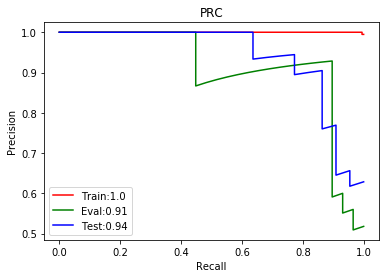

In [27]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.2 are labeled as "0". 
## Editing levels >= 0.2 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.2,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.2,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.2,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

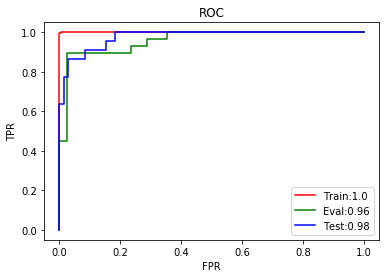

In [28]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.2,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.2,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.2,test_pred)

auroc_train=roc_auc_score(train_y>=0.2,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.2,eval_pred)
auroc_test=roc_auc_score(test_y>=0.2,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

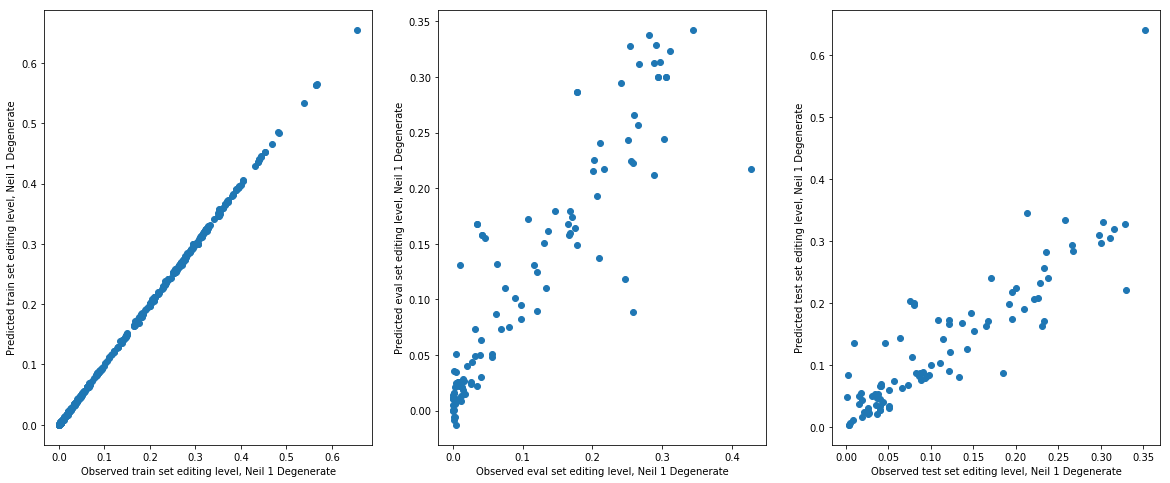

In [29]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [32]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':'TTYH2_COMP'})

In [33]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.13431169
0.8819515526260503
0.25966666298100405
The R-square of the test data is  0.706 



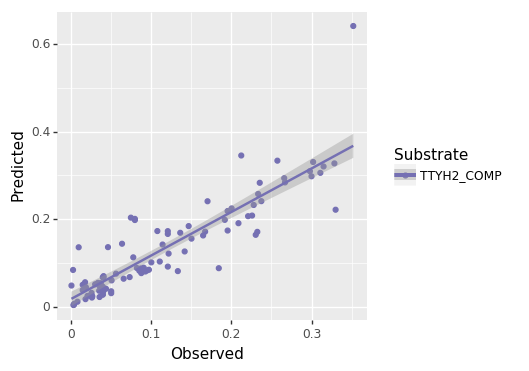

<ggplot: (-9223363261339732932)>


/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:708: UserWarning:

Saving 4 x 4 in image.

/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:709: UserWarning:

Filename: TTYH2.comp.substrate.svg



In [34]:
plotnine.options.figure_size = (4, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#7570b3'],name="Substrate"))
print(p)
ggsave(plot=p, filename='TTYH2.comp.substrate.svg',width=4,height=4,units='in')


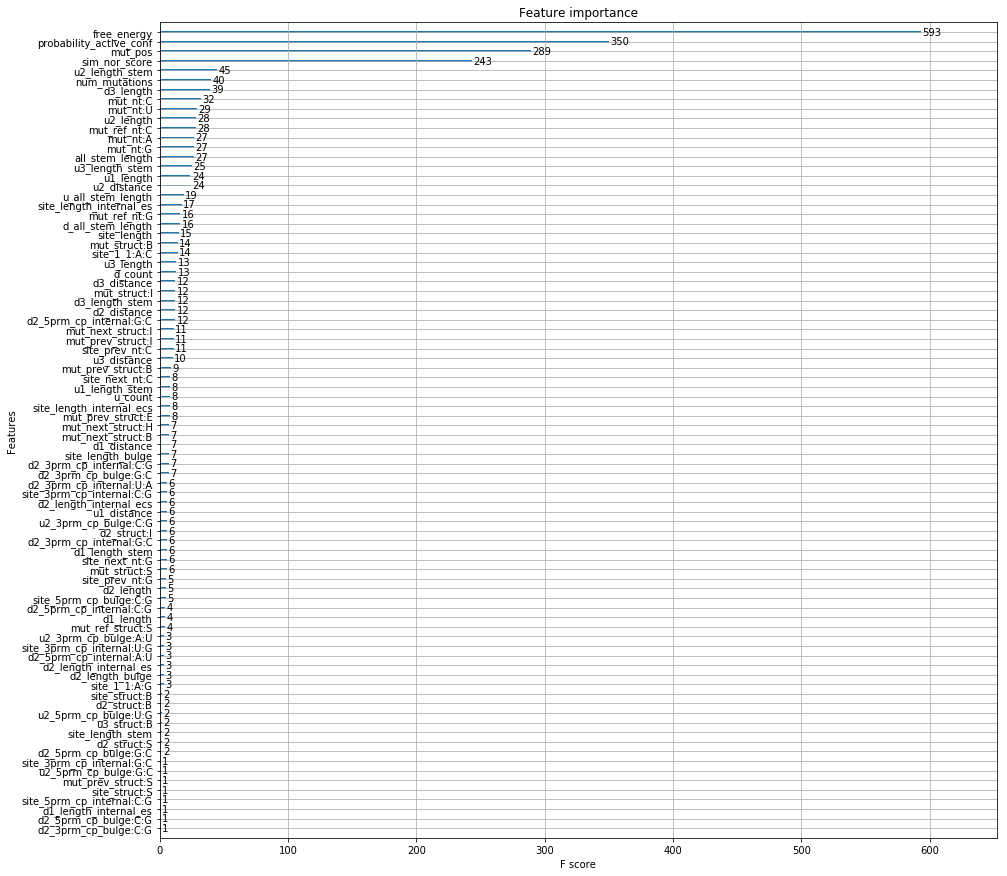

In [35]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

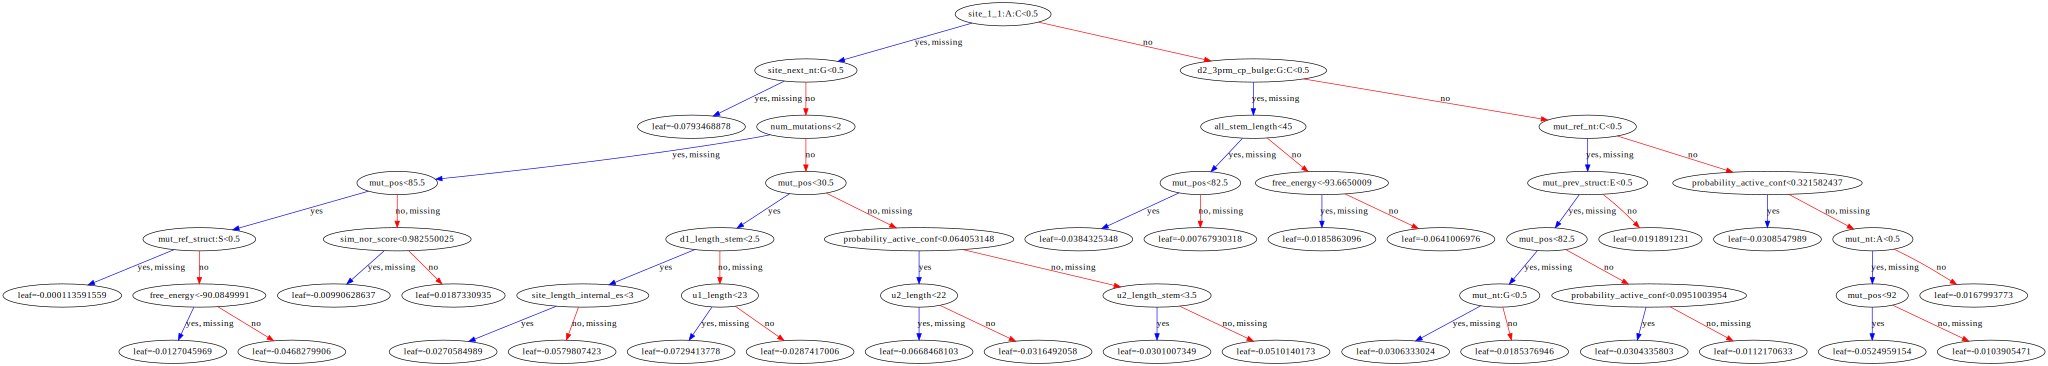

In [36]:
xgboost.to_graphviz(bst, num_trees=2)


In [37]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(93, 133)

In [38]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [39]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [40]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

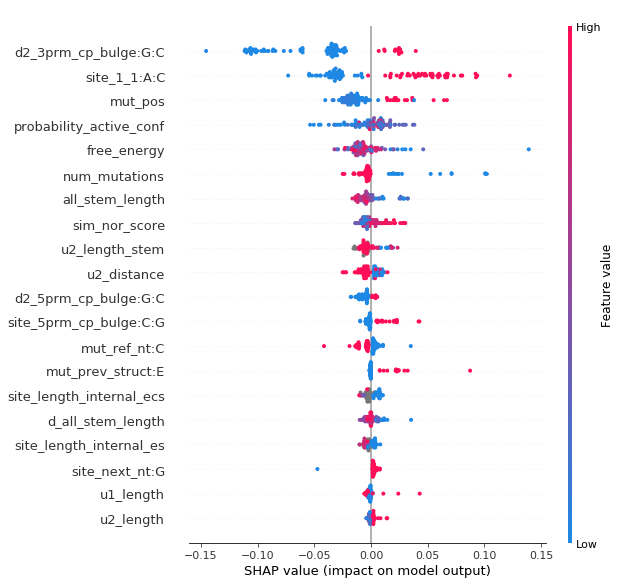

In [41]:
## summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.savefig("TTYH2.comp.shap.svg", format='svg',width=30,height=10,dpi=300,bbox_inches="tight")
# summarize the effect of all the features 
#shap.summary_plot(shap_values, test_X,show=True)
#plt.gca().set_facecolor('white')
#plt.gca().set_axisbelow(True)
#plt.gca().grid(linestyle='-', linewidth='0.5', color='#eeeeee')

#plt.gcf().set_size_inches(5, 10)

#plt.savefig("TTYH2.comp.shap.svg", format='svg',width=20,height=10,dpi=300,bbox_inches="tight")


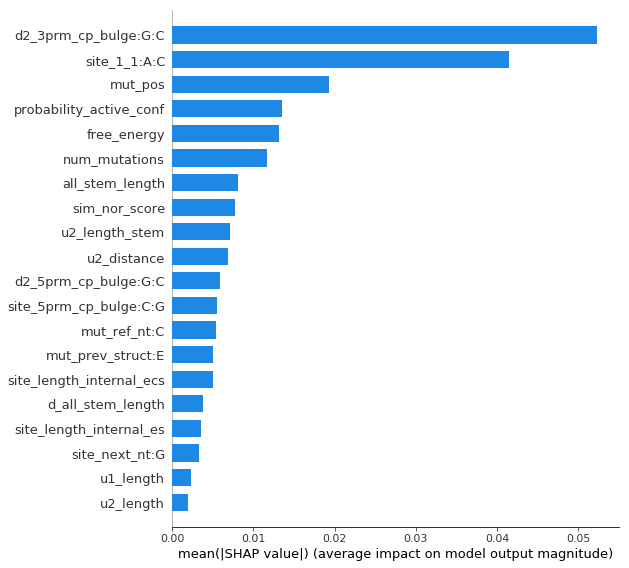

In [42]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [44]:
mean_abs_shap_vals=np.mean(abs(shap_values),axis=0)
features=test_X.columns
shap_dict=pd.DataFrame({'feature':features,
          'mean_abs_shap':mean_abs_shap_vals})
shap_dict.to_csv("TTYH2_comp_shap_mean_abs.txt",index=False,sep='\t')

In [45]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(93, 133, 133)

In [46]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [47]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [48]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [49]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['site_prev_nt*', 'site_next_nt*']


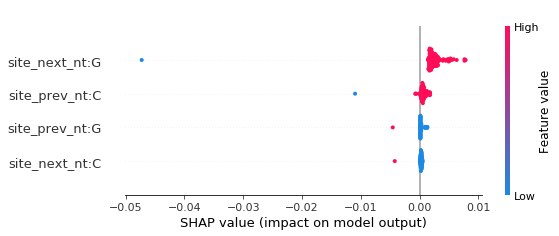

Contribution/Total:0.017963186
['free_energy*', 'sim_nor_score*', 'probability_active_conf*']


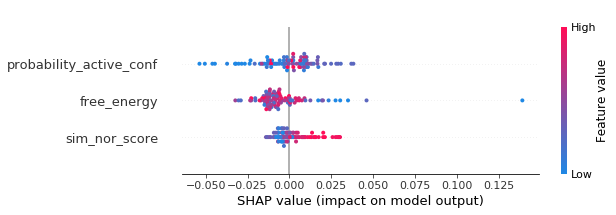

Contribution/Total:0.13213405
['u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*']


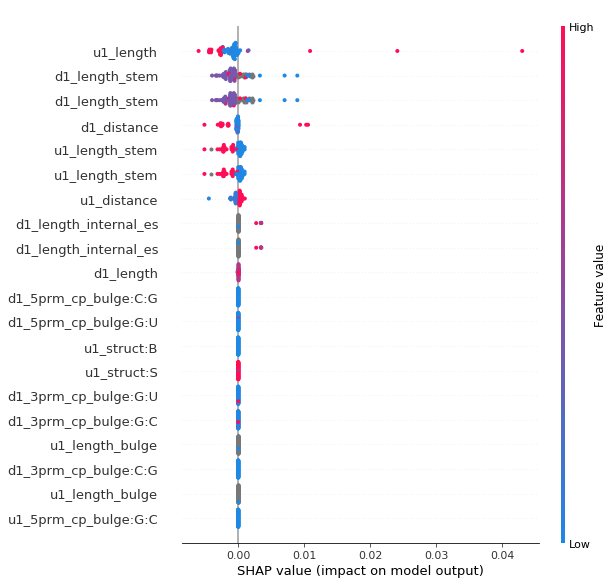

Contribution/Total:0.03358629
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


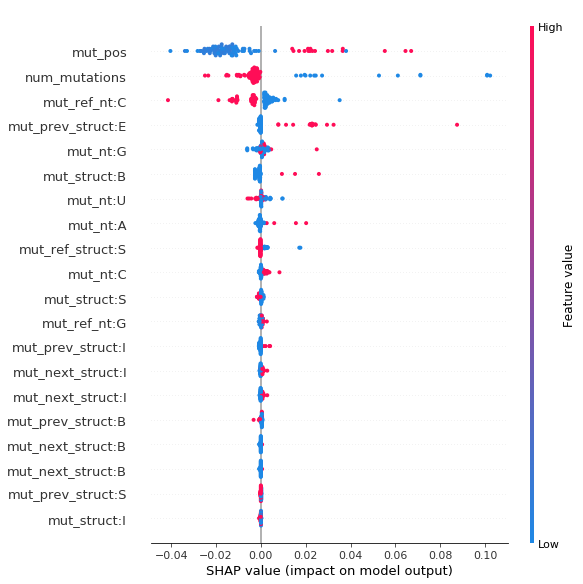

Contribution/Total:0.19878648
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


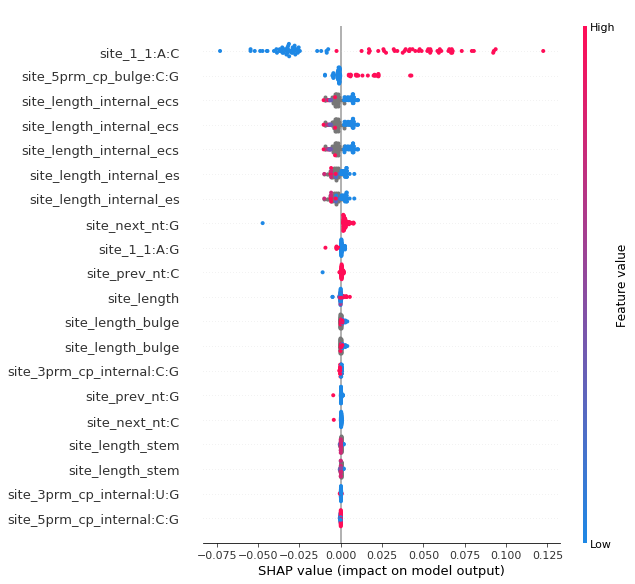

Contribution/Total:0.29630366
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


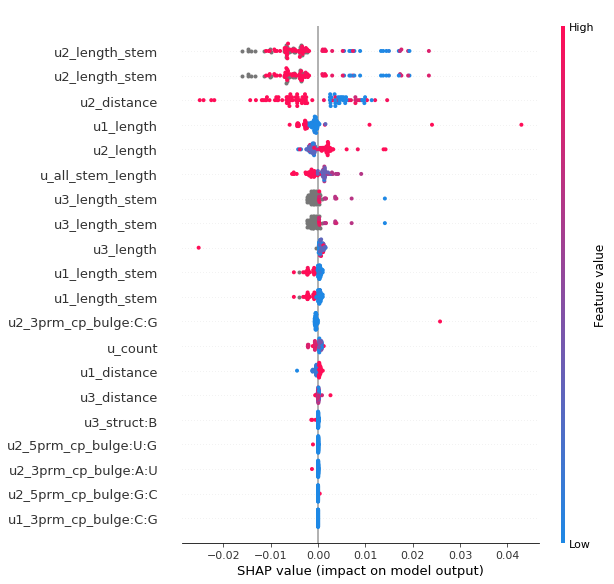

Contribution/Total:0.13210449
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


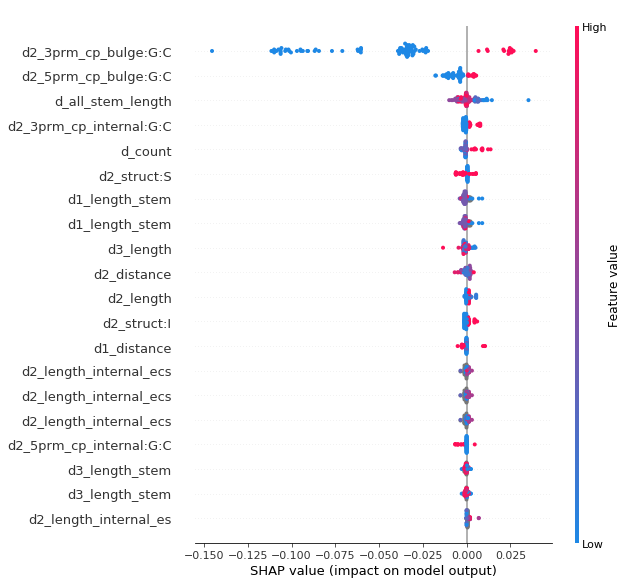

Contribution/Total:0.31808802
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*',

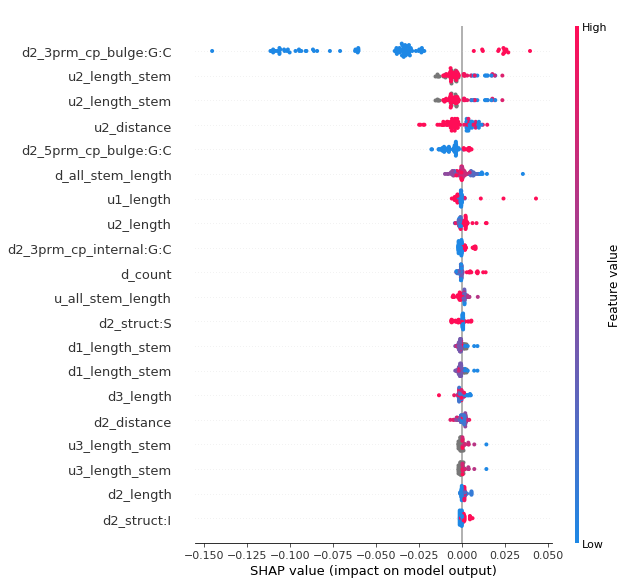

Contribution/Total:0.4501925
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


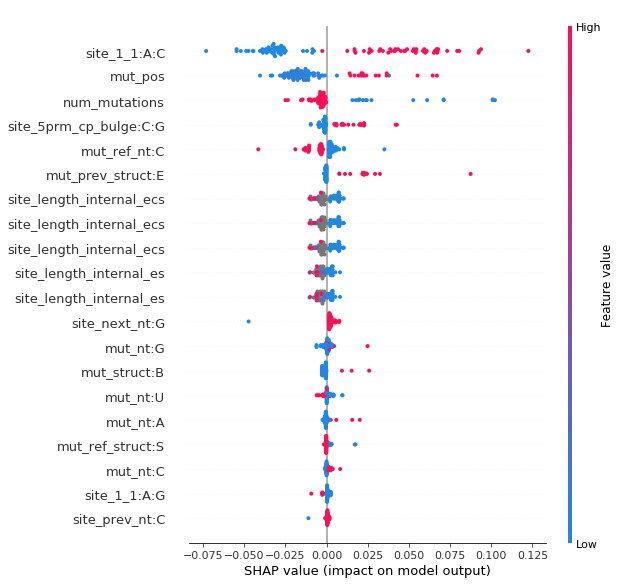

Contribution/Total:0.49509013
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_

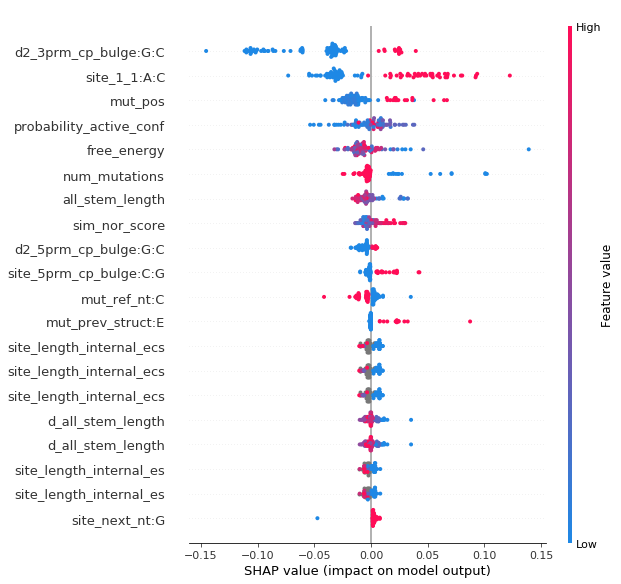

Contribution/Total:0.99785906
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*',

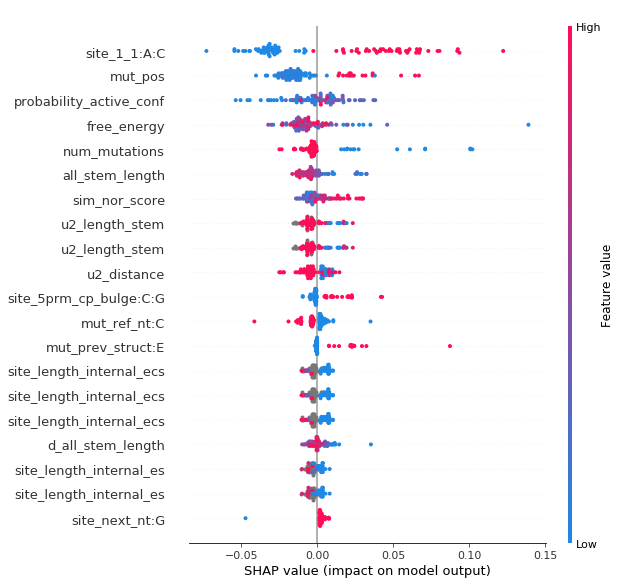

Contribution/Total:0.81187546
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


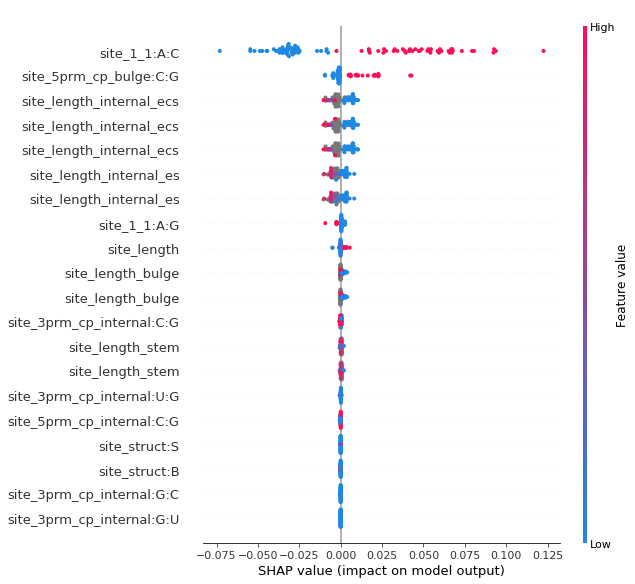

Contribution/Total:0.27834046
['site_prev_nt*', 'site_next_nt*']


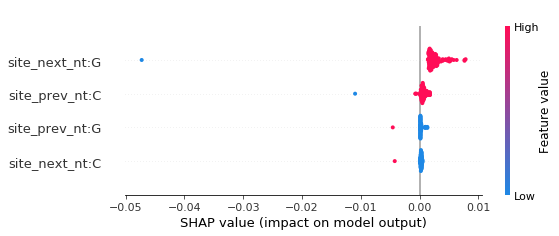

Contribution/Total:0.017963186
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


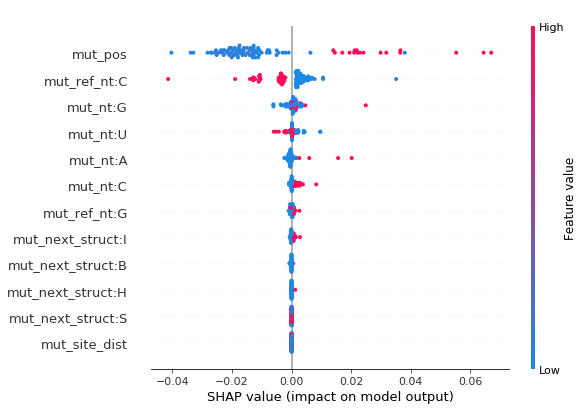

Contribution/Total:0.11770146
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


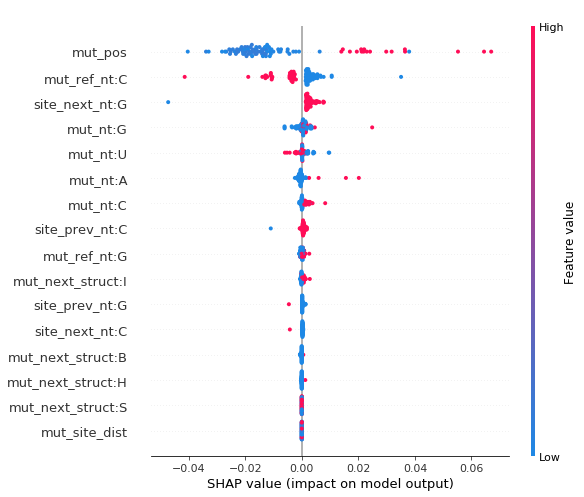

Contribution/Total:0.13566464
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_c

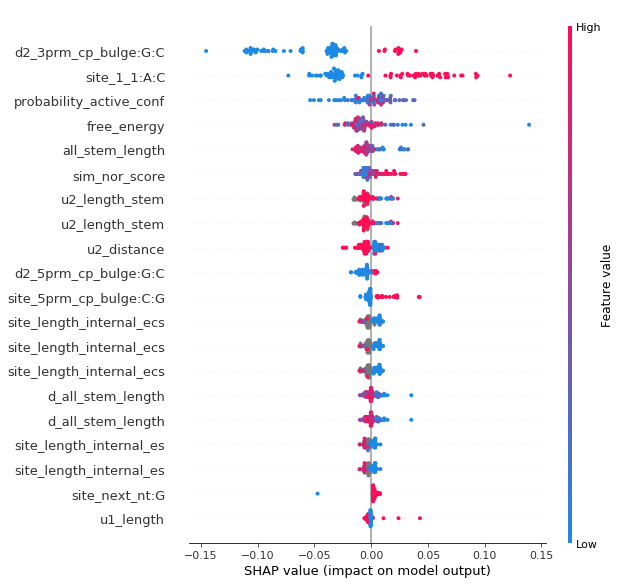

Contribution/Total:0.93117714
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


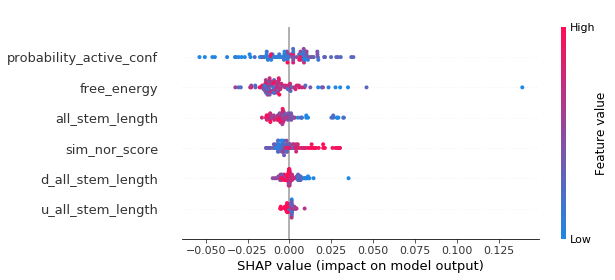

Contribution/Total:0.18468088


In [72]:
from feature_subsets import * 
subset_names=["sub_site_seq","biophysical","u1_d1","mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [sub_site_seq,biophysical,u1_d1,mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [73]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [74]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 

In [75]:
from pandas.api.types import CategoricalDtype

In [76]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)


In [77]:
subset_contrib_df

Subset  Contribution         Subset_Cat
0               no_up     99.785906              no_up
1              no_mut     93.117714             no_mut
2             no_down     81.187546            no_down
3            mut_site     49.509013           mut_site
4                 u_d     45.019251                u_d
5                   d     31.808802                  d
6                site     29.630366               site
7         site_struct     27.834046        site_struct
8                 mut     19.878648                mut
9   overall_structure     18.468088  overall_structure
10       mut_seq_site     13.566464       mut_seq_site
11        biophysical     13.213405        biophysical
12                  u     13.210449                  u
13            mut_seq     11.770146            mut_seq
14              u1_d1      3.358629              u1_d1
15           site_seq      1.796319           site_seq
16       sub_site_seq      1.796319       sub_site_seq

/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:708: UserWarning:

Saving 5 x 4 in image.

/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:709: UserWarning:

Filename: TTYH2.comp.subset.importance.svg



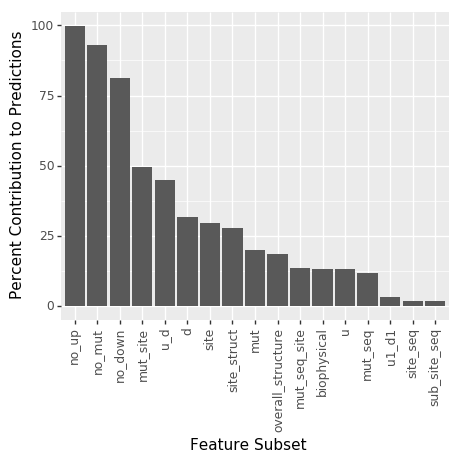

<ggplot: (-9223363261529507219)>

In [78]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + ylab("Percent Contribution to Predictions")
 + theme(axis_text_x=element_text(angle=90))
)
ggsave(plot=p, filename='TTYH2.comp.subset.importance.svg',width=5,height=4,units='in')
p

## No "mut" features

In [69]:
## Read in the data 
import pandas as pd 
import feature_subsets
data=pd.read_csv("../xin_feature_matrices/ttyh2_bc_degenerate_computational.features.csv",header=0,sep=',',index_col=0)
#drop all mut features
cur_features=filter_features(data,feature_subsets.mut)
cur_features.remove('mut_pos')
data=data.drop(cur_features,axis=1)
data.head

<bound method NDFrame.head of         editing_value  free_energy  sim_nor_score  mut_exist  mut_type  \
rna_id                                                                   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0002         0.4685       -87.80         1.0000          1  mismatch   
DG0003         0.4750       -86.09         0.9054          1  mismatch   
DG0004         0.4320       -91.62         0.8571          1  mismatch   
DG0005         0.4280       -87.05         1.0000          0        wt   
DG0006         0.4190       -79.98         0.8386          1  mismatch   
DG0006         0.4190       -79.98         0.8386          1  mismatch   
DG0006  

In [70]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [17]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(363, 144)
{24.0: 32, 25.0: 33, 26.0: 41, 27.0: 42, 28.0: 31, 29.0: 23, 30.0: 24, 31.0: 34, 32.0: 25, 33.0: 21, 48.0: 37, 67.0: 20}


In [0]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [0]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [20]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append("mut_pos")
print("\n".join(to_drop))

d2_3prm_cp_bulge:G:U
d3_length_internal_es
site_1_1_internal:A:C
mut_ref_struct:S
d3_3prm_cp_internal
u1_length_internal_ecs
site_3prm_cp_internal:A:U
d2_5prm_cp_internal:C:G
mut_ref_struct:I
site_5prm_cp_internal:U:G
u1_5prm_cp_hairpin
d2_5prm_cp_hairpin
u1_length_internal_es
d2_5prm_cp_internal:U:G
u1_exist
u3_struct:B
d3_length_bulge
u2_5prm_cp_internal
d3_length_internal_ecs
site_3prm_cp_bulge:G:C
d2_struct:I
d1_length_hairpin
d2_length_hairpin
u1_length_hairpin
d2_3prm_cp_internal:G:U
d2_exist
u3_length_internal_es
d3_5prm_cp_hairpin
u1_5prm_cp_internal
d2_5prm_cp_internal:G:C
site_length_hairpin
d3_3prm_cp_bulge
u3_length_internal_ecs
u3_5prm_cp_bulge:G:C
u2_length_internal_es
d2_length_internal_ecs
u2_3prm_cp_internal
u3_5prm_cp_internal
u1_3prm_cp_internal
u3_exist
u2_length_internal_ecs
mut_pos
site_3prm_cp_internal:G:U
u3_3prm_cp_bulge:G:C
d2_length_internal_es
site_prev_nt:C
site_5prm_cp_bulge:C:G
d3_length_hairpin
site_5prm_cp_hairpin
site_3prm_cp_internal:U:G
u3_3prm_cp_in

In [0]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [0]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [23]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(251, 81)
(251,)
(23, 81)
(23,)
(88, 81)
(88,)


In [0]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [0]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [0]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [27]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[01:21:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.85424	eval-mae:0.300791	eval-map:1	eval-aucpr:0.351996	eval-rmse:0.317974	train-auc:0.878831	train-mae:0.308405	train-map:1	train-aucpr:0.523933	train-rmse:0.321316
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[01:21:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.85424	eval-mae:0.213549	eval-map:1	eval-aucpr:0.351996	eval-rmse:0.224108	train-auc:0.879894	train-mae:0.218649	train-map:1	train-aucpr:0.527942	train-rmse:0.227875
[01:21:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-auc:0.85276	eval-mae:0.153696	eval-map:1	eval-aucpr:0.353326	eval-rmse:0.160337	train-auc:0.888925	train-mae:0.154888

In [0]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt')


In [0]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [30]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9970657610513067, pvalue=6.407769228827444e-280)
Eval:SpearmanrResult(correlation=0.8879551682781266, pvalue=1.5807367711631063e-08)
Test:SpearmanrResult(correlation=0.9966190757117951, pvalue=3.9453368701214976e-95)


Pearson correlation:
Train:(0.9999910497909579, 0.0)
Eval:(0.8331940538988964, 8.01387553265599e-07)
Test:(0.9713831172722682, 1.801596764445235e-55)


In [31]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0004404448208313764
MAE Eval:0.015877278029351776
MAE Test:0.007296456017277455


In [32]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.5520204994737%
MAPE Eval:5.7267138026827835%
MAPE Test:3.748163430455493%


In [33]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0007046191826184421
RMSE Eval:0.07432461432606262
RMSE Test:0.044804205240375775


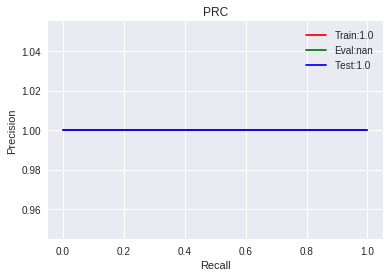

In [34]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

In [35]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

ValueError: ignored

In [0]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [0]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

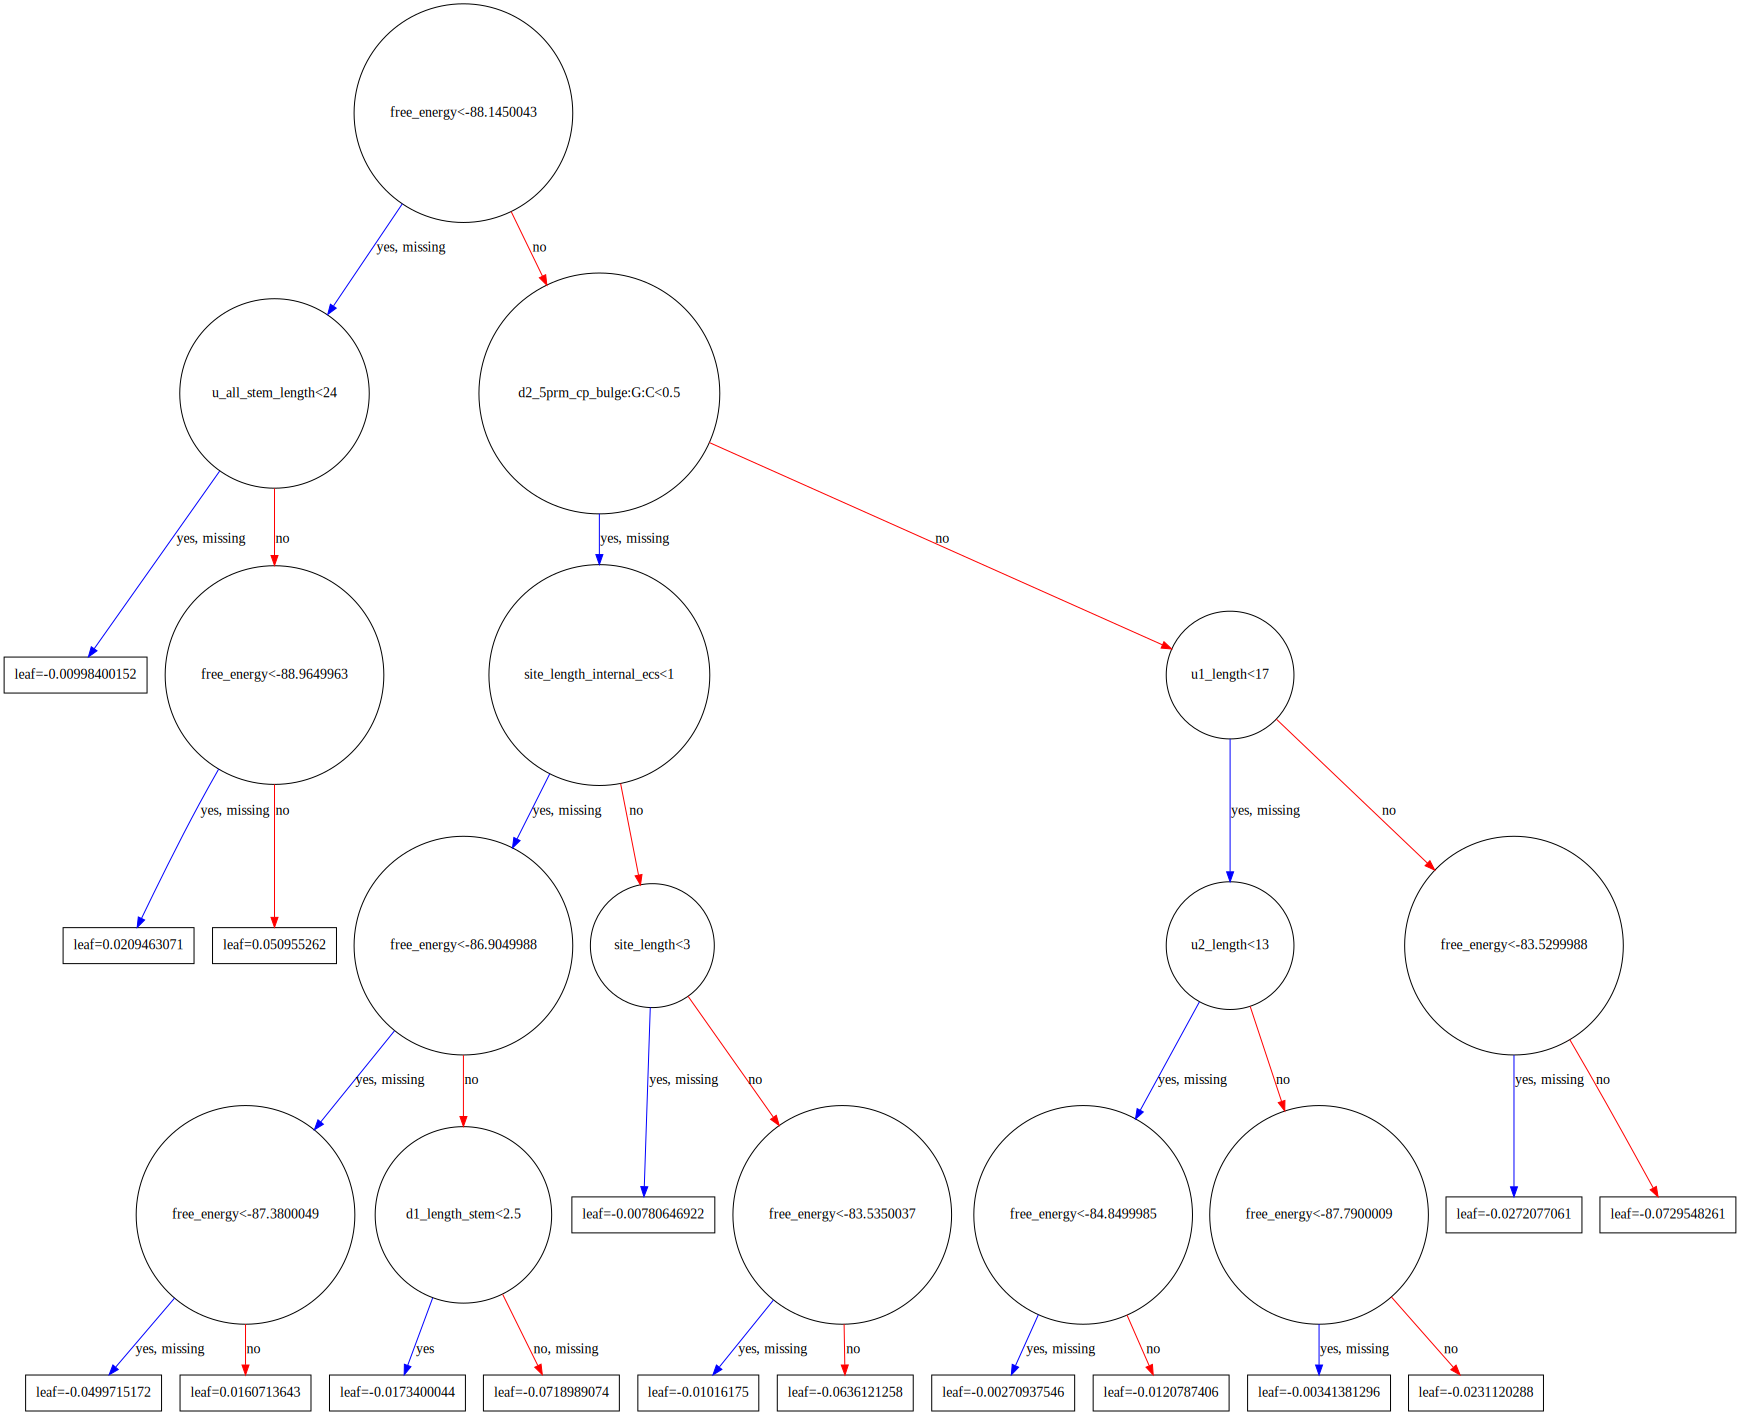

In [36]:
xgboost.to_graphviz(bst, num_trees=2)


In [37]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(88, 81)

In [38]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [39]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [40]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

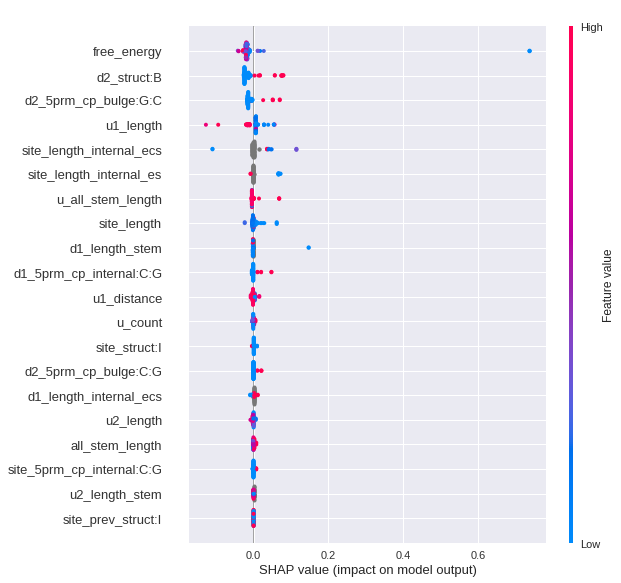

In [41]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


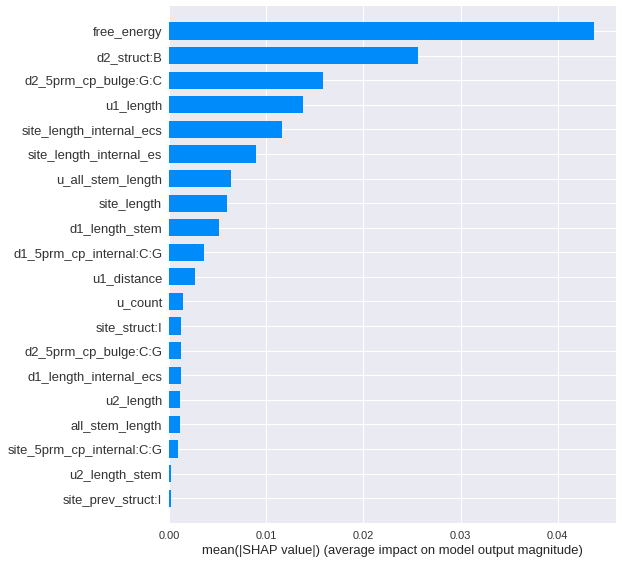

In [42]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [43]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(88, 81, 81)

In [0]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [0]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [46]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
